<a href="https://colab.research.google.com/github/datle2403/datle2403/blob/main/Combining_different_model_for_esemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idea of a simple majority vote classifier

Build a strong meta-classifier to balance out the individual classifier weakness.
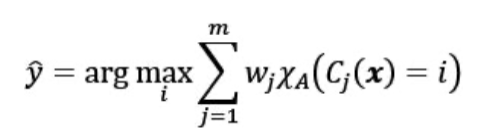

wj: weight associated with base classifier Cj, y^ is predicted class for esemble. Xa is a set of class label. Which return 1 if the predicted class of base classifier Cj match i.

For equal weight, we can write this.
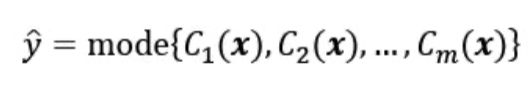

Example of weight:
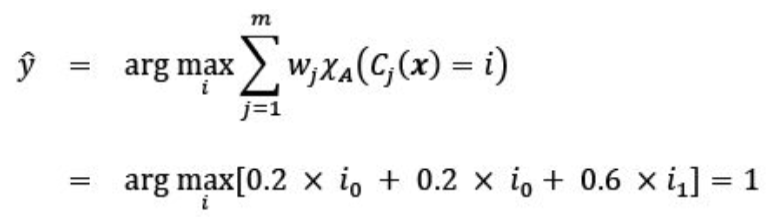

In [ ]:
import numpy as np
np.argmax(np.bincount([0,0,1],weights=[0.2,0.2,0.2]))

0

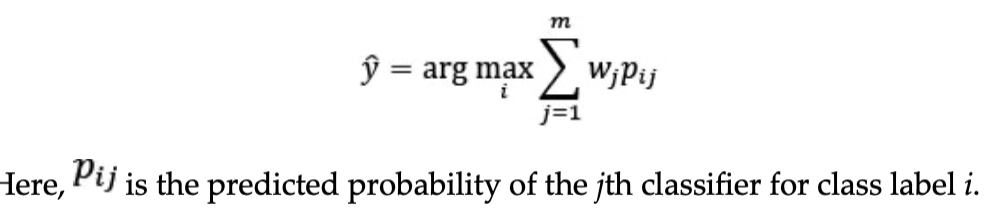

In [ ]:
ex=np.array([[0.2,0.8],[0.9,0.1],[0.6,0.4]])
p=np.average(ex,axis=0,weights=[0.2,0.2,0.6])
p

array([0.58, 0.42])

# Building MajorityVote Class and use Iris as example

BaseEstimator and ClassifierMixin parent classes to get some base functionality for free, including the get_params and set_params methods to set and return the classifier's parameters, as well as the score method to calculate the prediction accuracy.

In [19]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
from sklearn.preprocessing import LabelEncoder
import numpy as np
import operator
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
  def __init__(self, classifiers, vote='classlabel', weights=None):

      self.classifiers = classifiers
      self.name_classifiers = {key: value for key, value in _name_estimators(classifiers)}
      self.vote = vote
      self.weights = weights
  def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

  def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
  def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
  def get_params(self, deep=True):
    """ Get classifier parameter names for GridSearch"""
    if not deep:
        return super(MajorityVoteClassifier, self).get_params(deep=False)
    else:
        out = self.name_classifiers.copy()
        for name, step in self.name_classifiers.items():
            for key, value in step.get_params(deep=True).items():
                out['%s__%s' % (name, key)] = value
        return out

In [20]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
iris=datasets.load_iris()
X,y=iris.data[50:,[1,2]],iris.target[50:]
le=LabelEncoder()
y=le.fit_transform(y)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,stratify=y,test_size=0.5)

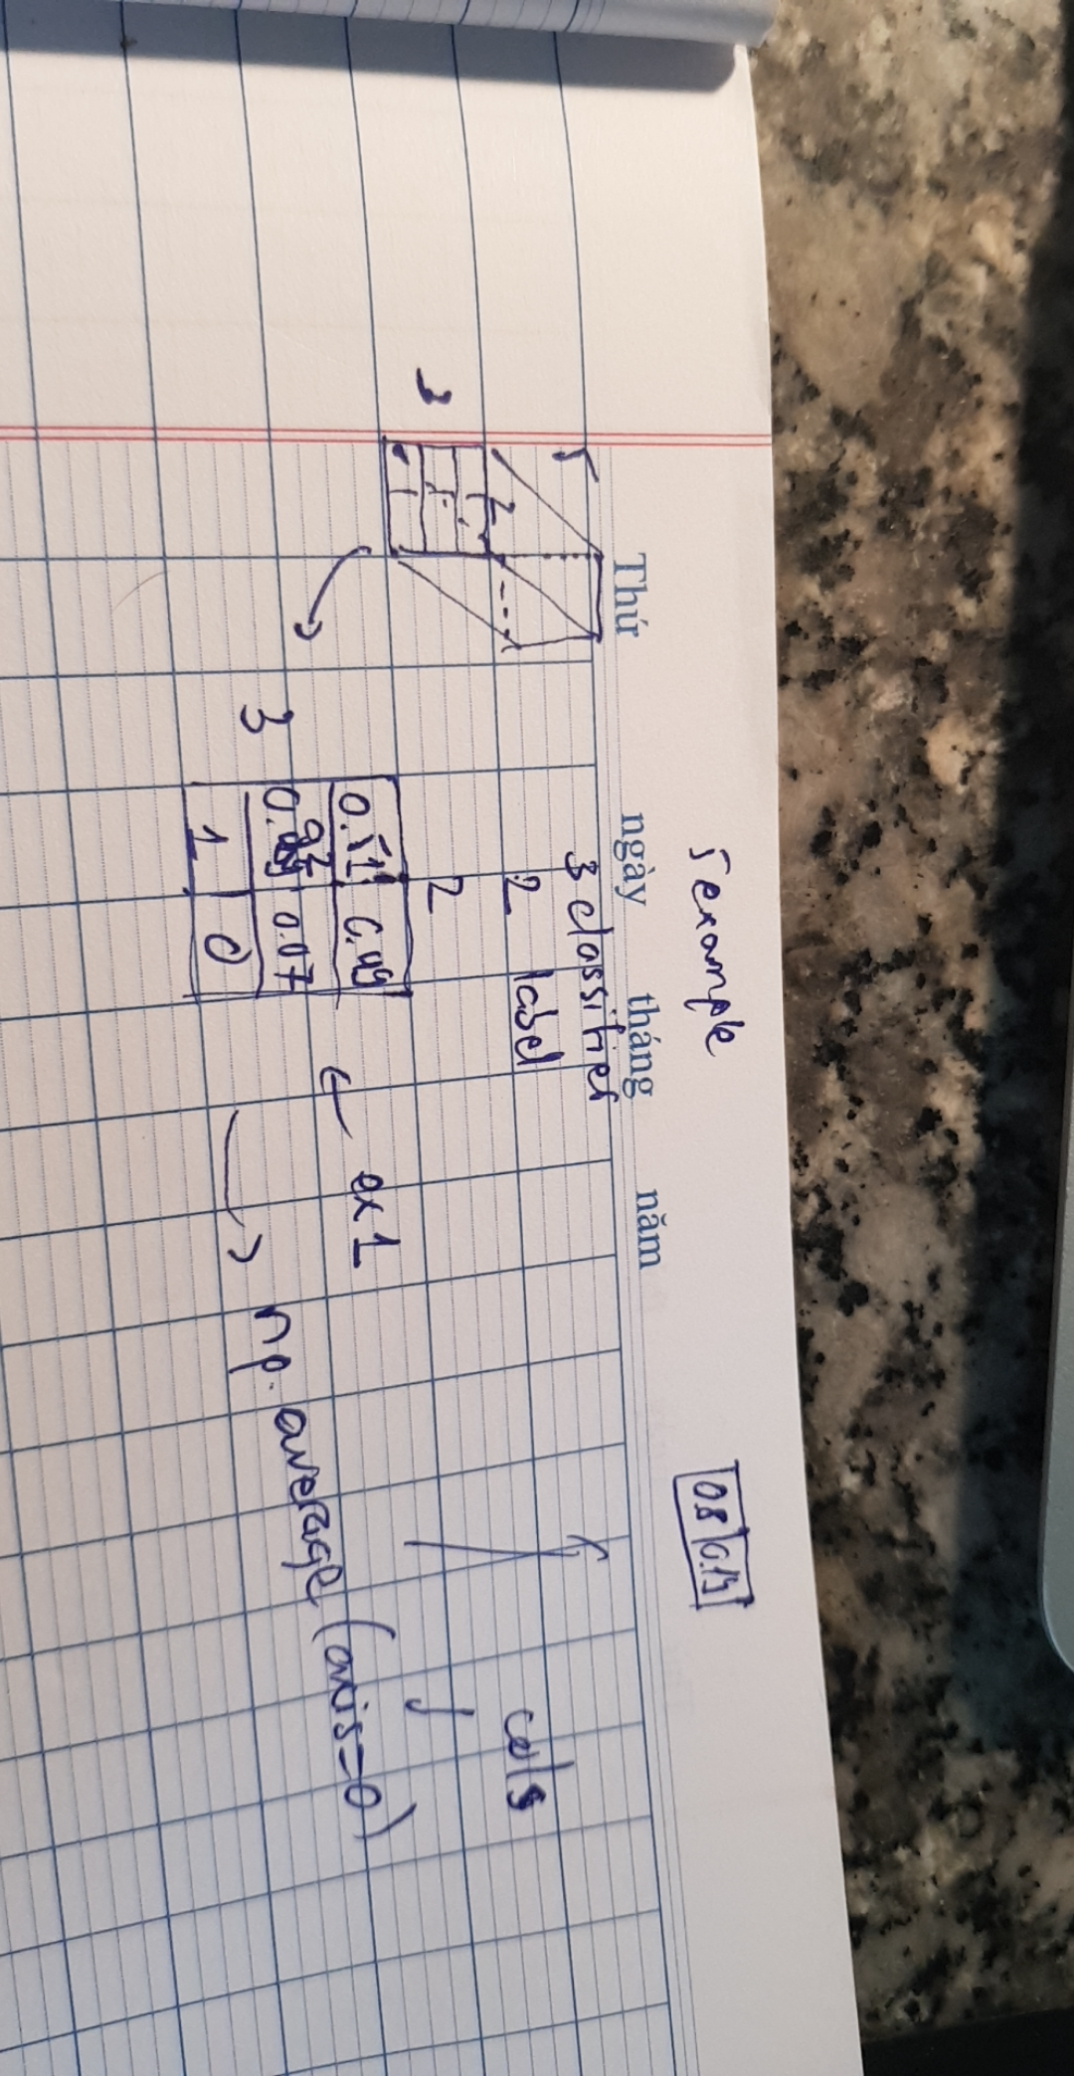

In [21]:
1/3*(0.50685474+0.92307692+1.)

0.8099772199999999

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
clf1=LogisticRegression(penalty='l2',solver='lbfgs',C=0.001,random_state=1)
clf2=DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=0)
clf3=KNeighborsClassifier(p=2,n_neighbors=1,metric='minkowski')
pipe1=Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3=Pipeline([['sc',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
  scores=cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,n_jobs=1,scoring='roc_auc')
  print('ROC auc: ',scores.mean(),'+-',scores.std(),' ',label)




ROC auc:  0.9166666666666666 +- 0.1536590742882148   Logistic regression
ROC auc:  0.8666666666666668 +- 0.18333333333333332   Decision tree
ROC auc:  0.85 +- 0.13333333333333333   KNN


ROC is a cure in graph, where x_axis is FPR( false positive rate), TPR(True Positive Rate).

In [23]:
mv_clf=MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels+='Majority_voting'
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf,label in zip(all_clf,clf_labels):
  scores=cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,n_jobs=1,scoring='roc_auc')
  print('ROC auc: ',scores.mean(),'+-',scores.std(),' ',label)

ROC auc:  0.9166666666666666 +- 0.1536590742882148   Logistic regression
ROC auc:  0.8666666666666668 +- 0.18333333333333332   Decision tree
ROC auc:  0.85 +- 0.13333333333333333   KNN
ROC auc:  0.9833333333333334 +- 0.04999999999999999   M


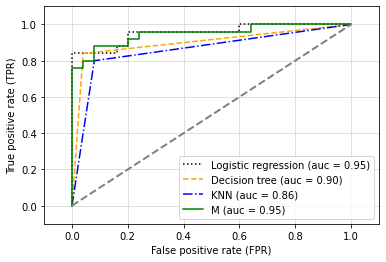

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('images/07_04', dpi=300)
plt.show()

However, you can see that the logistic regression classifier performs similarly well on the same dataset, which is probably due to the high variance (in this case, sensitivity of how we split the dataset) given the small size of the dataset:

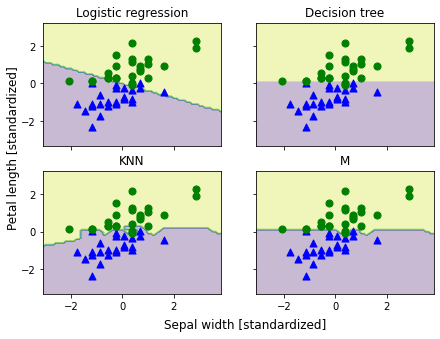

In [25]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

#plt.savefig('images/07_05', dpi=300)
plt.show()

In [26]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

Based on the values returned by the get_params method,

 we now know how to access the individual classifier's a ributes.

In [30]:
from sklearn.model_selection import GridSearchCV
params={'decisiontreeclassifier__max_depth':[1,2],'pipeline-1__clf__C':[0.001, 0.1, 100.0]}
gs=GridSearchCV(estimator=mv_clf,param_grid=params,scoring='roc_auc',n_jobs=1,cv=10,refit=True)
gs.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                           

In [31]:
gs.cv_results_

{'mean_fit_time': array([0.02382629, 0.00863585, 0.01179578, 0.00891774, 0.00877945,
        0.00979495]),
 'std_fit_time': array([0.00765813, 0.00169334, 0.002907  , 0.00192569, 0.00238989,
        0.00068553]),
 'mean_score_time': array([0.0093112 , 0.00277359, 0.00322962, 0.00408347, 0.0028666 ,
        0.0029815 ]),
 'std_score_time': array([0.00631494, 0.00021395, 0.00067633, 0.00258563, 0.00060658,
        0.00055577]),
 'param_decisiontreeclassifier__max_depth': masked_array(data=[1, 1, 1, 2, 2, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_pipeline-1__clf__C': masked_array(data=[0.001, 0.1, 100.0, 0.001, 0.1, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'decisiontreeclassifier__max_depth': 1,
   'pipeline-1__clf__C': 0.001},
  {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1},
  {'decisiontr

In [33]:
for mean,std in zip(gs.cv_results_['mean_test_score'],gs.cv_results_['std_test_score']):
  print(mean,'+-',std)

0.9833333333333334 +- 0.04999999999999999
0.9833333333333334 +- 0.04999999999999999
0.9666666666666668 +- 0.09999999999999998
0.9833333333333334 +- 0.04999999999999999
0.9833333333333334 +- 0.04999999999999999
0.9666666666666668 +- 0.09999999999999998


In [34]:
gs.best_params_

{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}

In [35]:
gs.best_score_

0.9833333333333334


# Bagging- building an esemble classifier using bootstrap sample with wine dataset

Introduction:
> Bagging is a esemble learning technique that nearly same as MajorityVoting but instead of fed the same dataset to each classifier, we draw bootstrap sample(ramdom sample with replacement) from initial dataset.
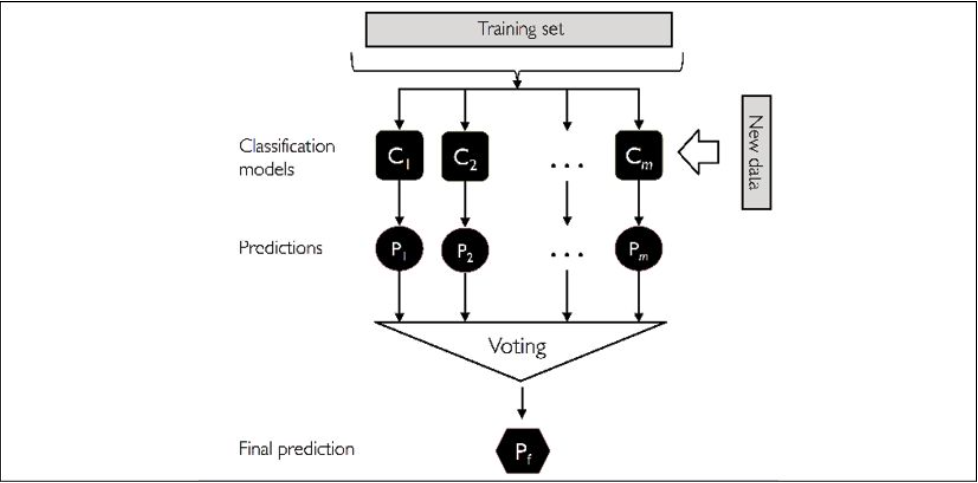

This technique seem equal to randomforest.

Apply bagging to wine dataset

In [37]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
df_wine=df_wine[df_wine['Class label']!=1]
y=df_wine.iloc[:,0].values
X=df_wine.iloc[:,[1,12]].values

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le=LabelEncoder()
y=le.fit_transform(y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)


In [53]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
tree=DecisionTreeClassifier(max_depth=None,random_state=1,criterion='entropy')
bag=BaggingClassifier(base_estimator=tree,n_estimators=500,max_features=1.,max_samples=1.,bootstrap=True,bootstrap_features=False,n_jobs=1,random_state=1)

In [54]:
tree.fit(X_train,y_train)
y_1=tree.predict(X_test)
y_2=tree.predict(X_train)
score=accuracy_score(y_test,y_1)
score1=accuracy_score(y_train,y_2)

In [55]:
score,score1

(0.8333333333333334, 1.0)

In [56]:
bag.fit(X_train,y_train)
y_1=bag.predict(X_test)
score=accuracy_score(y_test,y_1)
print(score)

0.9166666666666666


Text(0, -0.2, 'Alcohol')

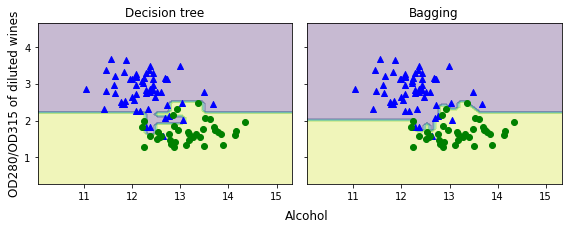

In [57]:
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

Bagging is approach to reduce the variance of model.

We perform bagging in model that have low bias (Decision tree).

# Leveraging weak learner through adaptive boosting


AdaBoost: the esemble consist of very simple base classifiers, known as weak learners. (such as decision tree stump)

In constrast to Bagging, the inital dataset or ramdomly sample without replacement
Main idea:
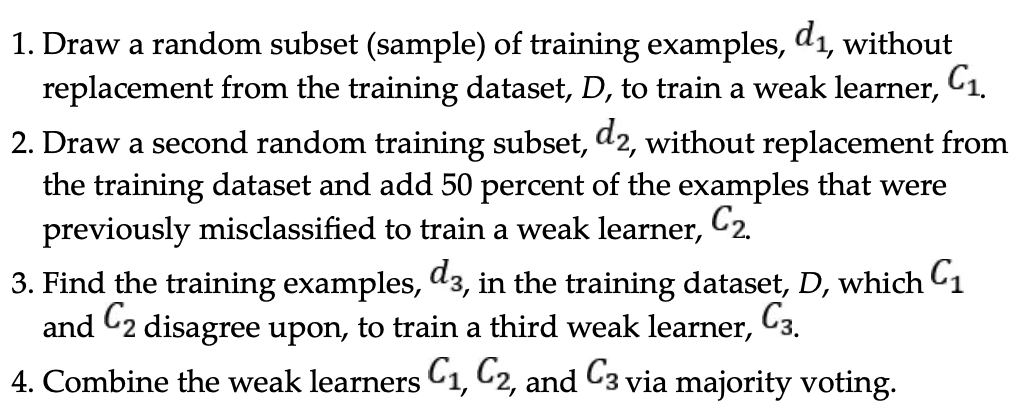

Apply AdaBoost using sklearn

In [59]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
df_wine=df_wine[df_wine['Class label']!=1]
y=df_wine.iloc[:,0].values
X=df_wine.iloc[:,[1,12]].values
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le=LabelEncoder()
y=le.fit_transform(y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

In [64]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(criterion='entropy',max_depth=1,random_state=1)
ada=AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)

In [65]:
tree.fit(X_train,y_train)
pred=accuracy_score(y_test,tree.predict(X_test))
pred

0.875

In [66]:
ada.fit(X_train,y_train)
pred=accuracy_score(y_test,ada.predict(X_test))
pred

0.9166666666666666

Text(0, -0.2, 'Alcohol')

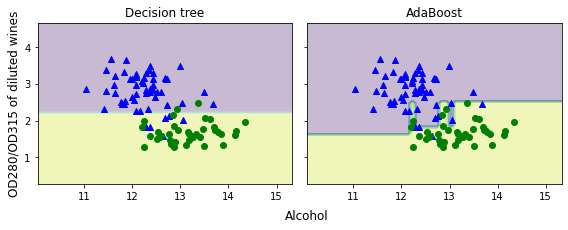

In [67]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)